In [1]:
import mne
import numpy
import pandas
import matplotlib.pyplot as plt
import mne
import mne_bids
import os
import pathlib
import numpy as np
mne.set_log_level('WARNING')

### **Loading Data**

In [2]:
files = os.listdir(r"Dataset")

hc = []
for file in files:
    if "hc" in str(file):
        hc.append(file.split("-")[1])
    

pd = []
for file in files:
    if "pd" in str(file):
        pd.append(file.split("-")[1])

In [3]:
raws_hc = []
raws_pd_on = []
raws_pd_off = []
events_g = []
count = 1

In [4]:
def loadAndPreprocess(session):
    global count
    bids_root = pathlib.Path(r'Dataset')
    bids_path = mne_bids.BIDSPath(subject=session[0],
                                    session=session[1],
                                    task='rest',
                            
                                    datatype='eeg',
                                    root=bids_root)
    raw = mne_bids.read_raw_bids(bids_path)
        
    
    
    # To Start from onset event
    tmin = 0 
    events, event_id = mne.events_from_annotations(raw)
    if events.shape[0] == 2 and "1" in event_id :
        tmin = events[1][0] * 0.001
    elif events.shape[0] == 1 and "1" in event_id:
        tmin = events[0][0] * 0.001    
    raw.crop(tmin = tmin)
    
    
    
    # only 3 miutes for each sample
    tmax = 180.
    raw.crop(tmax = tmax)
    
    
    
    # Excluding EXG Channels
    raw.pick_types(eeg=True, exclude=['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'])
    
    
    
    # Filtering
    raw.load_data().filter(l_freq = 0.5,h_freq=30)
    montage = mne.channels.make_standard_montage('easycap-M1')
    raw.set_montage(montage)
    

    #creating Stamps for events
    ev = 92160 * count
    if (session[1] == 'hc'):
        events_g.append([ev , 0 , 0])
        raws_hc.append(raw)

        
    elif (session[1] == 'off'):
        events_g.append([ev , 0 , 1])
        raws_pd_off.append(raw)

    else:
        events_g.append([ev, 0, 1])
        raws_pd_on.append(raw)
    
    
    count += 1
    

In [5]:
for hc0 in hc:
    hc_session = (hc0, "hc")
    loadAndPreprocess(hc_session)

for pd0 in pd:
    off_session = (pd0, "off")
    on_session = (pd0, "on")
    loadAndPreprocess(off_session)
    loadAndPreprocess(on_session)

C:\Users\sit\AppData\Local\Temp\ipykernel_15348\3410367340.py:10: RuntimeWarning: The unit for channel(s) Status has changed from NA to V.
  raw = mne_bids.read_raw_bids(bids_path)
C:\Users\sit\AppData\Local\Temp\ipykernel_15348\3410367340.py:10: RuntimeWarning: The unit for channel(s) Status has changed from NA to V.
  raw = mne_bids.read_raw_bids(bids_path)
C:\Users\sit\AppData\Local\Temp\ipykernel_15348\3410367340.py:10: RuntimeWarning: The unit for channel(s) Status has changed from NA to V.
  raw = mne_bids.read_raw_bids(bids_path)
C:\Users\sit\AppData\Local\Temp\ipykernel_15348\3410367340.py:10: RuntimeWarning: The unit for channel(s) Status has changed from NA to V.
  raw = mne_bids.read_raw_bids(bids_path)
C:\Users\sit\AppData\Local\Temp\ipykernel_15348\3410367340.py:10: RuntimeWarning: The unit for channel(s) Status has changed from NA to V.
  raw = mne_bids.read_raw_bids(bids_path)
C:\Users\sit\AppData\Local\Temp\ipykernel_15348\3410367340.py:10: RuntimeWarning: The unit for 

In [6]:
raws = raws_hc + raws_pd_off + raws_pd_on

In [7]:
all_data = mne.io.concatenate_raws(raws)

In [8]:
event_id = {'hc': 0, 'pd': 1}
events = np.array(events_g)

In [9]:
tmin = -176
tmax = 0
baseline = (None, None)

epochs = mne.Epochs(all_data,
                    events=events,
                    event_id=event_id,
                    tmin=tmin,
                    tmax=tmax,
                    baseline=baseline,
                    preload=True,
                    event_repeated = 'error',
                    verbose=True)
epochs

Not setting metadata
46 matching events found
Setting baseline interval to [-176.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 90113 original time points ...
0 bad epochs dropped


Number of events,46
Events,hc: 16pd: 30
Time range,-176.000 – 0.000 s
Baseline,-176.000 – 0.000 s


#### **Using Proper definition**

In [10]:
tmin = -176
tmax = 0
baseline = (None, None)

epochs_noisy_np = mne.Epochs(all_data,
                    events=events,
                    event_id=event_id,
                    tmin=tmin,
                    tmax=tmax,
                    baseline=baseline,
                    preload=True,
                    event_repeated = 'error',
                    verbose=True)

Not setting metadata
46 matching events found
Setting baseline interval to [-176.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 90113 original time points ...
0 bad epochs dropped


In [11]:
def noise_add(sample):
    var = np.var(sample)
    noise = np.random.normal(0, var, sample.shape)
    sample+= 0.5 * noise

    return sample

In [12]:
for i in range(0, len(epochs_noisy_np)):
    epochs_noisy_np[i]._data = noise_add(epochs_noisy_np[i]._data)

In [13]:
epochs_noisy_np[0] == epochs[0]

True

In [14]:
epochs_final = mne.concatenate_epochs([epochs, epochs_noisy_np])

C:\Users\sit\AppData\Local\Temp\ipykernel_15348\2643822982.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_final = mne.concatenate_epochs([epochs, epochs_noisy_np])


In [15]:
epochs_noisy_np.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 highpass: 0.5 Hz
 line_freq: 60.0
 lowpass: 30.0 Hz
 meas_date: 2011-01-19 11:22:56 UTC
 nchan: 32
 projs: []
 sfreq: 512.0 Hz
 subject_info: 6 items (dict)
>

In [16]:
epochs.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 highpass: 0.5 Hz
 line_freq: 60.0
 lowpass: 30.0 Hz
 meas_date: 2011-01-19 11:22:56 UTC
 nchan: 32
 projs: []
 sfreq: 512.0 Hz
 subject_info: 6 items (dict)
>

In [17]:
epochs_final.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 highpass: 0.5 Hz
 line_freq: 60.0
 lowpass: 30.0 Hz
 meas_date: 2011-01-19 11:22:56 UTC
 nchan: 32
 projs: []
 sfreq: 512.0 Hz
 subject_info: 6 items (dict)
>

### **Feature Extraction**

In [18]:
from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = epochs.events[:, -1]
y = le.fit_transform(labels)
X = epochs.get_data()

# CSP
csp = CSP(n_components=20, norm_trace=False)
X_out = csp.fit_transform(X,y)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = X_out.reshape((X_out.shape[0],-1))
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0, stratify = y)

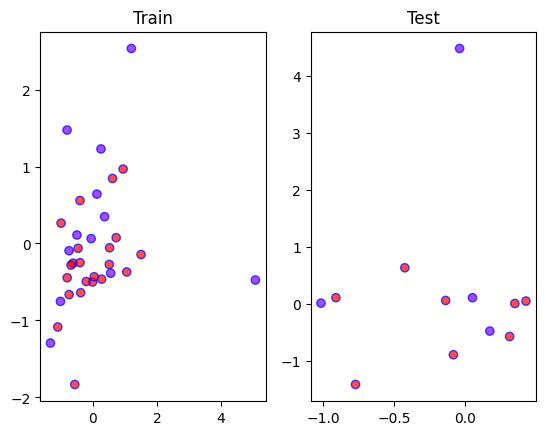

In [20]:
%matplotlib inline
plt.subplot(1,2,1)
plt.title("Train")
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='rainbow',alpha=0.7,edgecolors='b')

plt.subplot(1,2,2)
plt.title("Test")
plt.scatter(X_test[:,0],X_test[:,1],c=y_test,cmap='rainbow',alpha=0.7,edgecolors='b')

plt.show()

### **Classification Model**

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import pandas as pd
import time
import seaborn as sns

#### GridSearchCV

In [22]:
def gridsearchCV(estimator,features_,):
    gridSearchModel = GridSearchCV(estimator = estimator,
                                   param_grid = features_,
                                   verbose = 2,
                                   cv=4,
                                   n_jobs=-1,
                                   scoring="accuracy")
    return gridSearchModel

#### RandomForest Classifier

In [23]:
def randomForest_():
    randomForestmodel = RandomForestClassifier(criterion="gini",
                                               random_state=0,
                                               n_jobs=-1,
                                               oob_score=True)
    features = dict(max_depth= [2,3,5,10,20],
    min_samples_leaf= [5,10,20,50,100,200],
    n_estimators= [10,25,30,50,100,200])
    model = gridsearchCV(randomForestmodel,features)
    return model

#### Logistic Regression

In [24]:
def logistic():
    Logisticmodel = LogisticRegression(max_iter=1000)
    features_ = dict(C = [0.001,0.01,0.1,1,10,100],
                     solver = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'])
    model = gridsearchCV(Logisticmodel,features_)
    return model

#### Decision Tree Classifier

In [25]:
def tree():
    # Making prediction with Decision Tree Classifier
    dtc = DecisionTreeClassifier(random_state=0)
    features_ = dict(criterion = ["gini","entropy","log_loss"],
                     max_depth= [2,3,5,10,20],
                    min_samples_leaf= [5,10,20,50,100,200])
    model = gridsearchCV(dtc,features_)
    return model

#### Support Vector Classifier

In [26]:
def svm():
    svmmodel = SVC(random_state=0)
    features_ = dict(C = [0.001,0.01,0.1,1,10,100],
                     kernel=['linear', 'poly', 'rbf', 'sigmoid'])
    model = gridsearchCV(svmmodel,features_)
    return model

#### Guassian Nave Baye's

In [27]:
def naive():
    gnb = GaussianNB()
    return gnb

#### XGBoost

In [30]:
from xgboost import XGBClassifier
def XGB():
  params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
  xgbmodel = XGBClassifier(n_estimators=10,
                        early_stopping_rounds=50,
                        max_depth=6,
                        booster="gbtree")
  model = gridsearchCV(xgbmodel,params)
  return model

#### Linear Discriminant Analysis

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def LDA():
    params = {
        "solver" : ["svd", "lsqr", "eigen"],
        "n_components" : [1],
        "store_covariance" : [True, False],
        "tol" : [0.0001, 0.001, 0.01, 0.1],
    }

    ldamodel = LinearDiscriminantAnalysis()
    model = gridsearchCV(ldamodel,params)
    return model


#### KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier
def KNN():
    knn = KNeighborsClassifier()
    k_range = list(range(1, 31))
    param_grid = dict(n_neighbors=k_range)
    model = gridsearchCV(knn,param_grid)
    return model

#### AdaBoost

In [40]:
from sklearn.ensemble import AdaBoostClassifier
def ada():
    param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2, 5, 10, 15]
             }


    DTC = DecisionTreeClassifier(random_state = 0, class_weight = "balanced",max_depth = None)
    ABC = AdaBoostClassifier(base_estimator = DTC)
    model = gridsearchCV(ABC,param_grid)
    return model

#### Neural Networks

In [34]:
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
def ner():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.compile(optimizer = 'adam',loss='sparse_categorical_crossentropy',metrics =['accuracy'])

    return model

#### Accuracy and F1 Score

In [35]:
def analysis(model,X_test,y_test):
    return f1_score(y_test,model.predict(X_test)), accuracy_score(y_test,model.predict(X_test))

#### ROC and AUC Curve

In [36]:
def auc_(model,X_test,y_test):
    return roc_auc_score(y_test,model.predict(X_test))

#### Predictive Models

In [37]:
# Creating a dataframe for various results
result_ = pd.DataFrame(columns=["model","f1Score","accuracy","training score","auc","time"])

def result(model,f1_score,accuracy,trainingScore ,auc, time):
    """This function creates a dataframe of all the information"""
    result_.loc[len(result_.index)] = [model,f1_score,accuracy,trainingScore,auc,time]

In [41]:
def predictiveModels():
        """t0 and t1 are for capturing the training time"""
# LOGISTIC REGRESSION
        t0 = time.time()
        logisticModel = logistic().fit(X_train,y_train) # Calling the logistic function to return logistic model
        t1 = time.time()-t0
        print(f"➡️Best model params for Logistic Regression --> {logisticModel.best_params_}")
        # trs_L = Training score for logistic regression 
        trs_L = logisticModel.score(X_train,y_train)
        f1_score_logistic, accuracy_logistic = analysis(logisticModel,X_test,y_test)
        acu_Logistic = auc_(logisticModel,X_test,y_test)
        result("LogisticRegression",f1_score_logistic,accuracy_logistic,trs_L,acu_Logistic,t1) # Creating a dataframe for the model
        
# DECISION TREE
        t0 = time.time()
        treeModel = tree().fit(X_train,y_train)
        t1 = time.time()-t0

        print(f"➡️Best model params for Decision Tree --> {treeModel.best_params_}")
        trs_T = treeModel.score(X_train,y_train)
        f1_score_tree, accuracy_tree = analysis(treeModel,X_test,y_test)
        acu_decision_tree = auc_(treeModel,X_test,y_test)
        result("Decison Tree",f1_score_tree,accuracy_tree,trs_T,f1_score_tree,t1)

# SUPPORT VECTOR MACHINE
        t0 = time.time()

        svmModel = svm().fit(X_train,y_train)
        t1 = time.time()-t0

        print(f"➡️Best model params for Support Vector Machines --> {svmModel.best_params_}")
        trs_S = svmModel.score(X_train,y_train)
        f1_score_svm, accuracy_svm = analysis(svmModel,X_test,y_test)
        acu_svm = auc_(svmModel,X_test,y_test)
        result("SVM",f1_score_svm,accuracy_svm, trs_S,acu_svm,t1) # Creating a dataframe for the model

#RANDOM FOREST
        t0 = time.time()

        randomForestModel = randomForest_().fit(X_train,y_train)
        t1 = time.time()-t0

        print(f"➡️Best model params for Random Forest Classifier --> {randomForestModel.best_params_}")
        trs_R = randomForestModel.score(X_train,y_train)
        f1_score_random, accuracy_random = analysis(randomForestModel,X_test,y_test)
        acu_random_forest = auc_(randomForestModel,X_test,y_test)
        result("Random Forest",f1_score_random,accuracy_random,trs_R,acu_random_forest,t1)

#NAIVE BAYES
        t0 = time.time()

        naiveModel = naive().fit(X_train,y_train)
        t1 = time.time()-t0

        trs_N = naiveModel.score(X_train,y_train)
        f1_score_naive, accuracy_naive = analysis(naiveModel,X_test,y_test)
        acu_naive = auc_(naiveModel,X_test,y_test)
        result("Naive Bayes",f1_score_naive,accuracy_naive,trs_N,acu_naive,t1)

#XGBOOST
        t0 = time.time()

        xgbModel = XGB().fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)], verbose=10)
        t1 = time.time()-t0

        print(f"➡️Best model params for XGBoost --> {xgbModel.best_params_}")
        trs_X = xgbModel.score(X_train,y_train)
        f1_score_xgb, accuracy_xgb = analysis(xgbModel,X_test,y_test)
        acu_xgb = auc_(xgbModel,X_test,y_test)
        result("XGBoost",f1_score_xgb,accuracy_xgb,trs_X,acu_xgb,t1)

#LDA
        t0 = time.time()
        ldaModel = LDA().fit(X_train,y_train)
        t1 = time.time()-t0

        print(f"➡️Best model params for LDA --> {ldaModel.best_params_}")
        trs_LDA = ldaModel.score(X_train,y_train)
        f1_score_lda, accuracy_lda = analysis(ldaModel,X_test,y_test)
        acu_lda = auc_(ldaModel,X_test,y_test)
        result("LDA",f1_score_lda,accuracy_lda,trs_LDA,acu_lda,t1)

#KNN
        t0 = time.time()
        knnModel = KNN().fit(X_train,y_train)
        t1 = time.time()-t0

        print(f"➡️Best model params for KNN --> {knnModel.best_params_}")
        trs_KNN = knnModel.score(X_train,y_train)
        f1_score_knn, accuracy_knn = analysis(knnModel,X_test,y_test)
        acu_knn = auc_(knnModel,X_test,y_test)
        result("KNN",f1_score_knn,accuracy_knn,trs_KNN,acu_knn,t1)

#ADABOOST
        t0 = time.time()
        adaModel = ada().fit(X_train,y_train)
        t1 = time.time()-t0
        
        print(f"➡️Best model params for AdaBoost --> {adaModel.best_params_}")
        trs_ADA = adaModel.score(X_train,y_train)
        f1_score_ada, accuracy_ada = analysis(adaModel,X_test,y_test)
        acu_ada = auc_(adaModel,X_test,y_test)
        result("AdaBoost",f1_score_ada,accuracy_ada,trs_ADA,acu_ada,t1)

#NEURALNETWORK
        t0 = time.time()
        neuModel = ner()
        history = neuModel.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test))
        t1 = time.time() - t0

        trs_neu = accuracy_score(y_train, neuModel.predict_classes(X_train, verbose=0))
        f1_score_neu, accuracy_neu = f1_score(y_test, neuModel.predict_classes(X_test, verbose=0)), accuracy_score(y_test, neuModel.predict_classes(X_test, verbose=0))
        acu_neu = roc_auc_score(y_test, neuModel.predict_classes(X_test, verbose=0))
        result("Neural Netwrok",f1_score_neu,accuracy_neu,trs_neu,acu_neu,t1)

In [42]:
predictiveModels()

Fitting 4 folds for each of 30 candidates, totalling 120 fits
➡️Best model params for Logistic Regression --> {'C': 10, 'solver': 'liblinear'}
Fitting 4 folds for each of 90 candidates, totalling 360 fits
➡️Best model params for Decision Tree --> {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
Fitting 4 folds for each of 24 candidates, totalling 96 fits
➡️Best model params for Support Vector Machines --> {'C': 1, 'kernel': 'linear'}
Fitting 4 folds for each of 180 candidates, totalling 720 fits
➡️Best model params for Random Forest Classifier --> {'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 25}
Fitting 4 folds for each of 405 candidates, totalling 1620 fits
[0]	validation_0-logloss:0.56350	validation_1-logloss:0.63763
[9]	validation_0-logloss:0.18089	validation_1-logloss:0.42592
➡️Best model params for XGBoost --> {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
Fitting 4 folds for each of 24 candidates, totalling

c:\Users\sit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.69791667 0.72916667 0.79166667 0.79166667 0.79166667 0.79166667
 0.73263889 0.78819444 0.67708333 0.73263889 0.64583333 0.64583333
 0.64583333 0.70486111 0.64583333 0.64583333 0.64583333 0.64583333
 0.64583333 0.64583333 0.64583333 0.64583333 0.64583333 0.64583333
 0.64583333        nan        nan        nan        nan        nan]
  warnings.warn(
c:\Users\sit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


➡️Best model params for KNN --> {'n_neighbors': 3}
Fitting 4 folds for each of 20 candidates, totalling 80 fits
➡️Best model params for AdaBoost --> {'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'random', 'n_estimators': 5}
Epoch 1/100
2/2 [==============================] - 1s 270ms/step - loss: 14.1527 - accuracy: 0.0000e+00 - val_loss: 9.2605 - val_accuracy: 0.0833
Epoch 2/100
2/2 [==============================] - 0s 45ms/step - loss: 11.2700 - accuracy: 0.0882 - val_loss: 6.1153 - val_accuracy: 0.0833
Epoch 3/100
2/2 [==============================] - 0s 43ms/step - loss: 9.6150 - accuracy: 0.1176 - val_loss: 5.4862 - val_accuracy: 0.1667
Epoch 4/100
2/2 [==============================] - 0s 37ms/step - loss: 8.0331 - accuracy: 0.1176 - val_loss: 3.0855 - val_accuracy: 0.1667
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 9.5396 - accuracy: 0.2059 - val_loss: 2.4204 - val_accuracy: 0.3333
Epoch 6/100
2/2 [=============================

c:\Users\sit\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\keras\engine\sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
c:\Users\sit\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\keras\engine\sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

In [43]:
result_

,model,f1Score,accuracy,training score,auc,time
0,LogisticRegression,0.933333,0.916667,1.000000,0.937500,4.349107
1,Decison Tree,0.666667,0.666667,0.823529,0.666667,0.321313
2,SVM,0.933333,0.916667,1.000000,0.937500,0.092345
3,Random Forest,0.941176,0.916667,0.911765,0.875000,18.968349
4,Naive Bayes,0.941176,0.916667,0.882353,0.875000,0.001990
5,XGBoost,0.800000,0.750000,0.941176,0.750000,3.271025
6,LDA,0.857143,0.833333,1.000000,0.875000,0.164604
7,KNN,0.888889,0.833333,0.823529,0.750000,0.435418
8,LogisticRegression,0.933333,0.916667,1.000000,0.937500,0.171766
9,Decison Tree,0.666667,0.666667,0.823529,0.666667,0.231005


In [44]:
def plotting(dataframe_,title1,title2,supertitle):

    sns.set_palette("Paired") # This is for theming palette
    plt.figure(figsize=(25,5)) # Setting up the figure size
    x = np.arange(dataframe_.shape[0]) # For x ticks purpose 


    plt.subplot(1,2,1) # First subplot
    plt.suptitle(supertitle,fontsize=15)

    plt.bar(x,dataframe_["training score"],width=0.3,label="train") # Plotting the line graph for training score
    for index,values in zip(x,dataframe_["training score"]): # This is for adding text to the graph
        plt.text(index-0.1,values/2,f"{values:.2f}",color="#576CBC")

    plt.bar(x+0.3,dataframe_["accuracy"],
            width=0.3,
            label="accuracy")
    for index,values in zip(x,dataframe_["accuracy"]):
        plt.text(index+0.2,values/2,f"{values:.2f}",color="#FFF2CC")

    plt.xticks(x,dataframe_["model"],rotation=50)
    plt.title(title1)
    plt.xlabel("Models")
    plt.ylabel("Training and Testing score")
    plt.legend()


    plt.subplot(1,2,2)


    plt.bar(x,dataframe_["f1Score"],width=0.3,label="f1Score")

    for index,values in zip(x,dataframe_["f1Score"]):
        plt.text(index,values/2,f"{values:.2f}",verticalalignment="bottom",horizontalalignment='center',color="#0B2447",fontsize="small")
    
    plt.bar(x+0.3,dataframe_["auc"],width=0.3,label="auc")

    for index,values in zip(x,dataframe_["auc"]):
        plt.text(index+0.3,values/2,f"{values:.2f}",verticalalignment="bottom",horizontalalignment='center',color="#0B2447",fontsize="small")

    
    plt.xticks(x,dataframe_["model"],rotation=45)
    plt.title(title2)
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

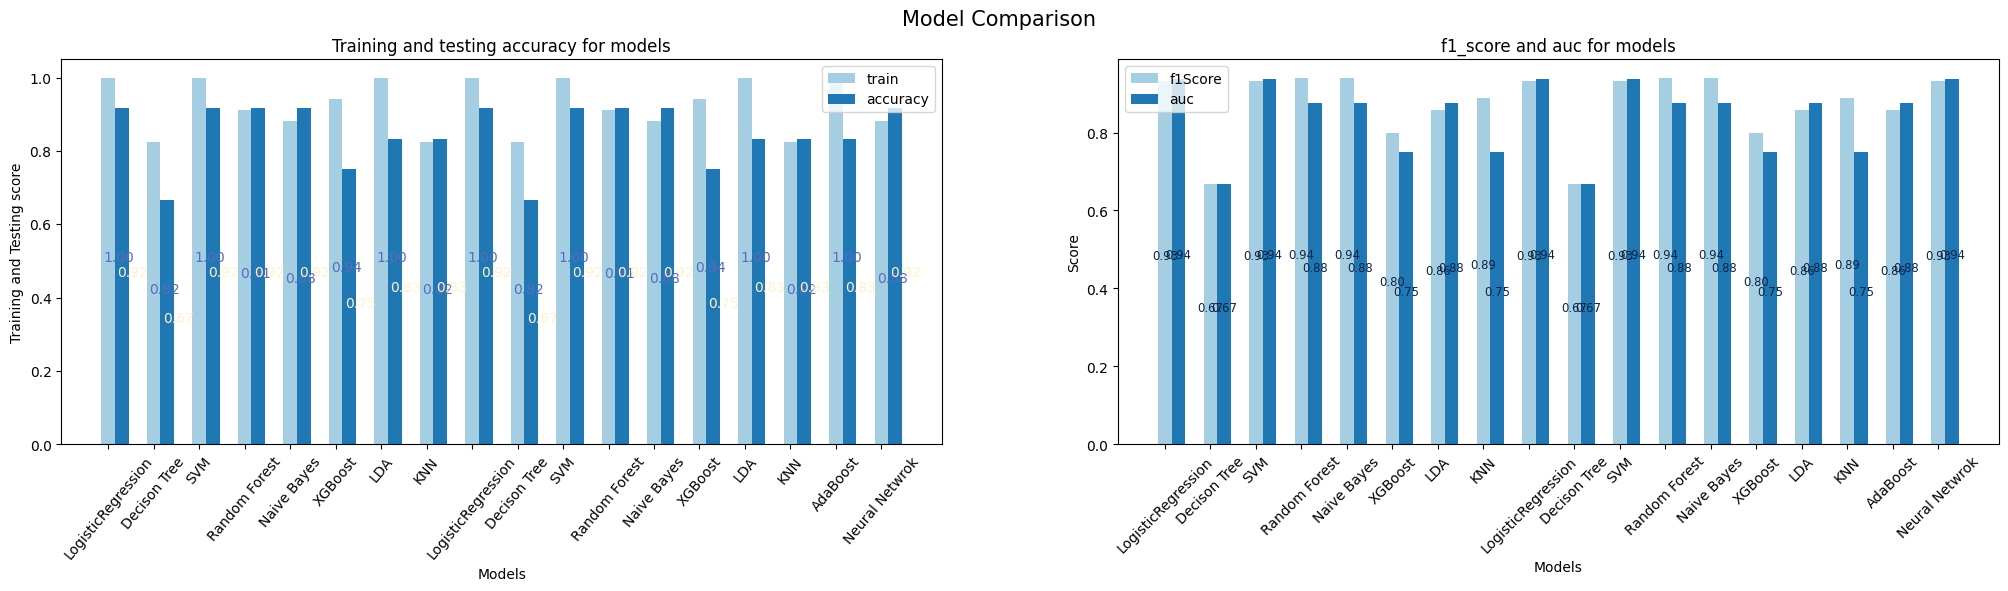

In [45]:
plotting(result_,title1 = "Training and testing accuracy for models",title2 = "f1_score and auc for models",supertitle="Model Comparison")

Text(0, 0.5, 'Training time')

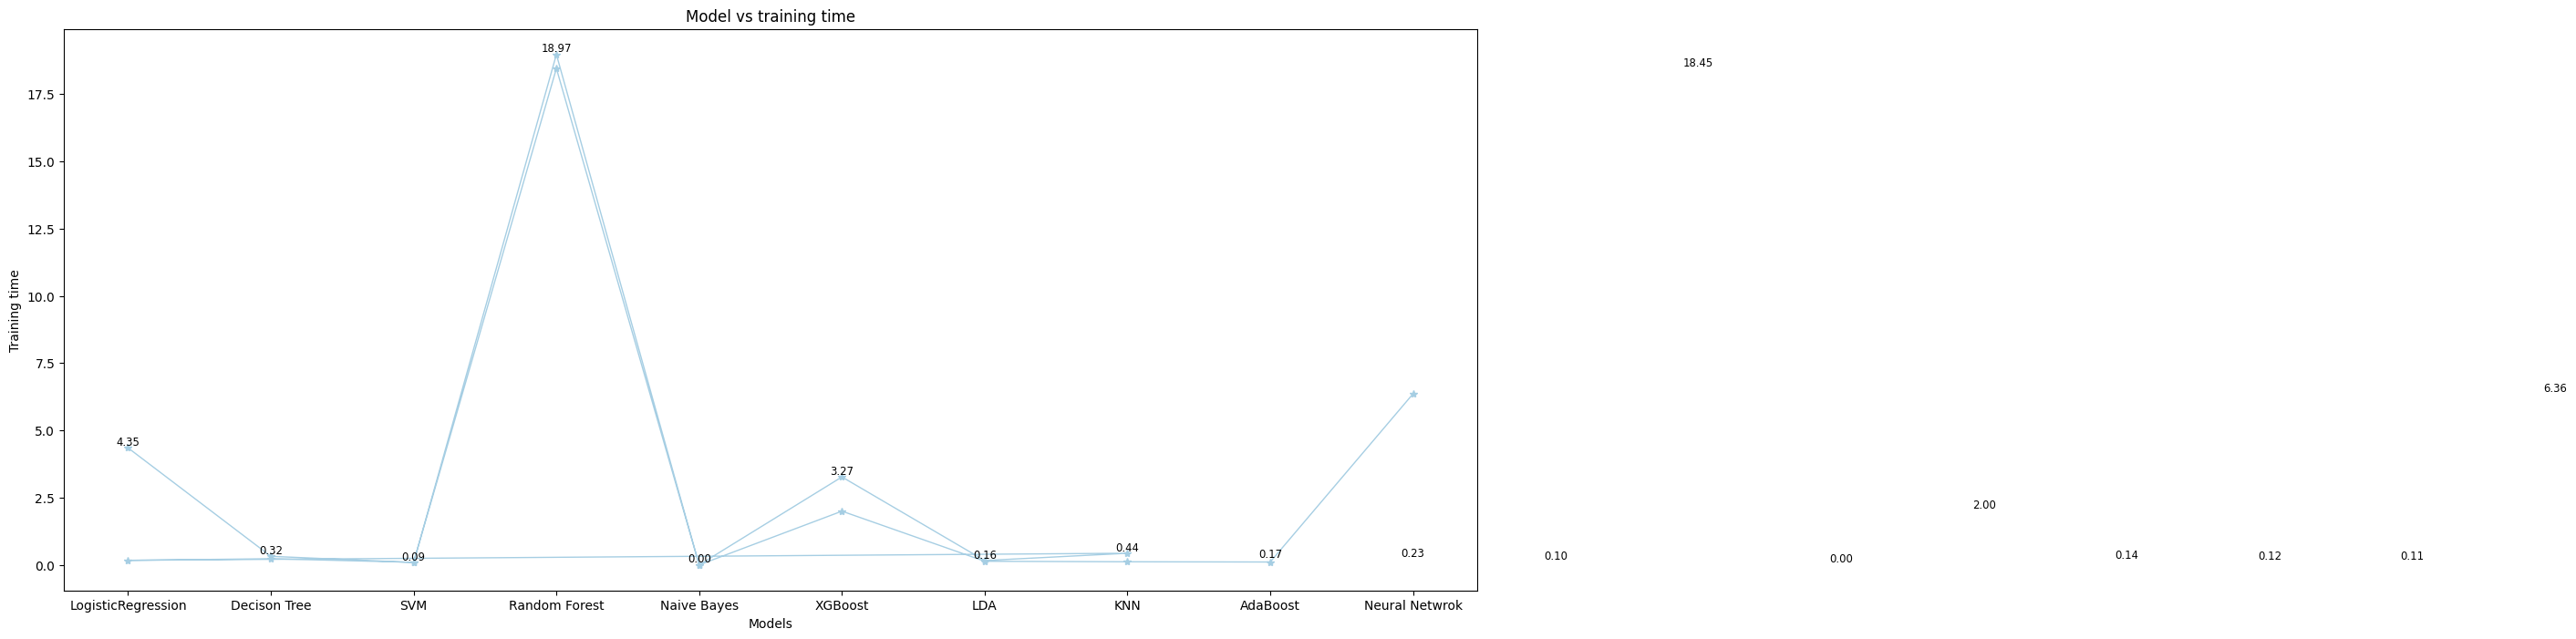

In [46]:
# Plotting the time for every model
plt.figure(figsize=(20,8))
plt.plot(result_["model"],result_["time"],marker="*",lw=1)
for x,val in enumerate(result_["time"]):
    plt.text(x,val,f"{val:.2f}",verticalalignment="bottom",fontsize='small',horizontalalignment="center")
plt.title("Model vs training time")
plt.xlabel("Models")
plt.ylabel("Training time")